# Proyecto 14

## Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Objetivos

- Construir un modelo para predecir la cantidad de pedidos de taxi de la próxima hora.
    - Utilizar la métrica RECM para medir el desempeño del modelo
    - La métrica no debe ser superior a 48

## Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


## Diagnóstico inicial


In [2]:
# Cargar dataset
data = pd.read_csv('taxi.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


(0.0, 40.0)

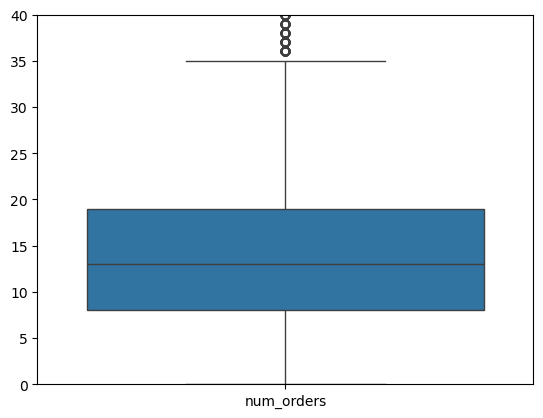

In [5]:
# Distribución de órdenes, ajustado de 0 a 40
sns.boxplot(data)
plt.ylim(0,40)

In [6]:
# Valores outliers
data.query('num_orders > 35')['num_orders'].count() / len(data) * 100


2.5928442028985508

<span style=color:blue>**Comentario**</span>

- El dataset incluye 26,496 registros en intervalos de 10 minutos, se requiere remuestreo a intervalos de 1 hora.
- No hay datos ausentes
- La columna datetime es tipo object, es necesario cambiarla a tipo datetime
- El 2.6% de los datos son valores atípicos. Serán eliminados.

## Preparación de los datos

In [7]:
# Cargar el documento, convertir la primera columna en tipo datetime y hacerla índice
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

# Ordenar índice en forma ascendente
data.sort_index(inplace=True)

# Comprobar si el índice está en órden cronológico ascendente
print(data.index.is_monotonic_increasing)

True


In [8]:
# Eliminación de valores atípicos
data = data.query('num_orders <= 35')


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25809 entries, 2018-03-01 00:00:00 to 2018-08-31 23:30:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  25809 non-null  int64
dtypes: int64(1)
memory usage: 403.3 KB


Text(0.5, 1.0, 'órdenes por cada 10 min')

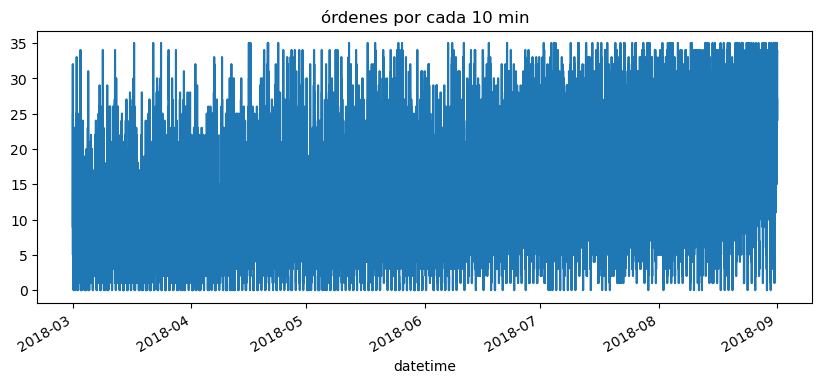

In [10]:
# Gráfico inicial
data.plot(figsize=[10,4], legend=False)
plt.title('órdenes por cada 10 min')

<span style=color:blue>**Comentario**</span>

El dataset, después de eliminar atípicos, incluye 25,809 registros, desde el 1 de marzo de 2018 hasta el 31 de agosto de 2018, en intervalos de 10 minutos.

### Remuestreo

In [11]:
## Remuestreo en intervalos de 1 hora
data_hour = data.resample('1h').sum()

Text(0.5, 1.0, 'órdenes por hora')

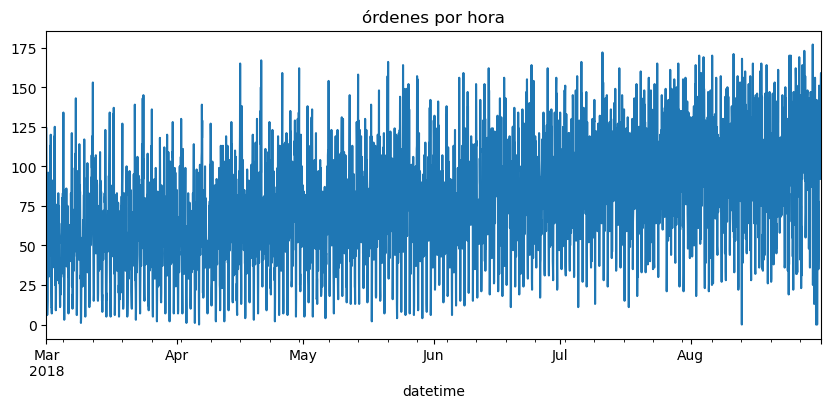

In [12]:
# Gráfico agrupado en 1 hora
data_hour.plot(figsize=[10,4], legend=False)
plt.title('órdenes por hora')

In [13]:
data_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [14]:
data_hour.describe()

,num_orders
count,4416.000000
mean,77.605299
std,34.281663
min,0.000000
25%,53.000000
50%,77.000000
75%,102.000000
max,177.000000


<span style=color:blue>**Comentario**</span>

El remuestreo se realizó efectivamente, agrupando 4416 horas, con un promedio de 77 taxis por hora, mínimo de 0 y máximo de 177.

### Descomposición de la serie

In [15]:
decomposed = seasonal_decompose(data_hour)

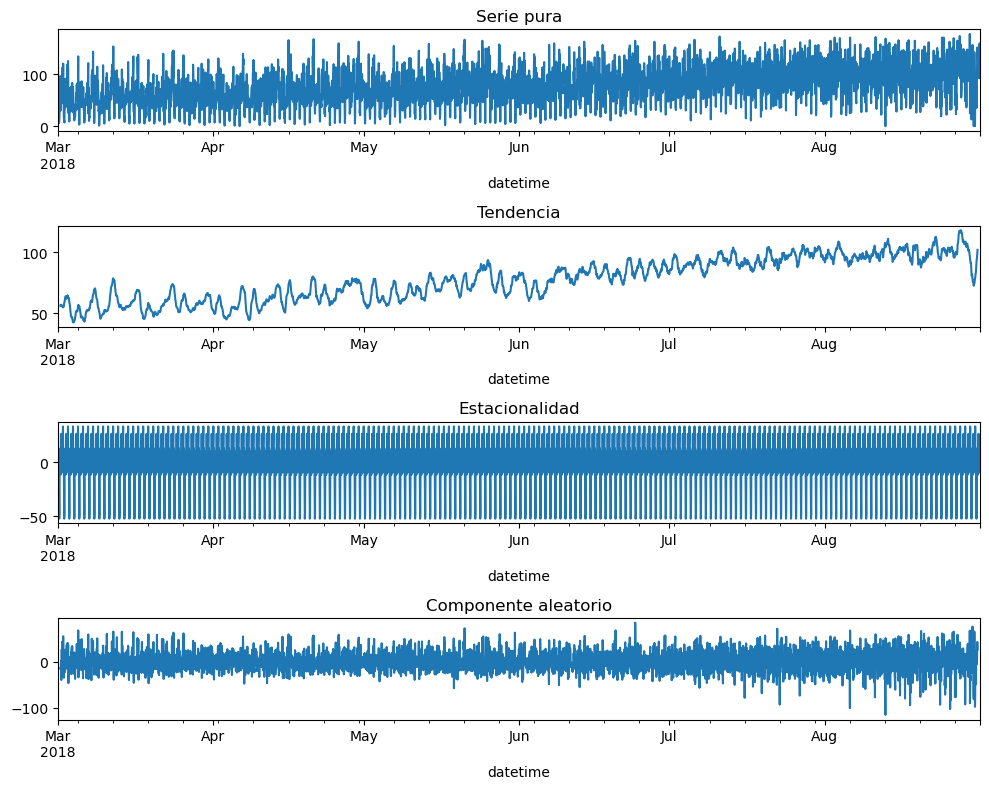

In [16]:
# Gráficos de descomposición de la serie temporal
plt.figure(figsize=(10, 8))

plt.subplot(411)
data_hour['num_orders'].plot(ax=plt.gca())
plt.title('Serie pura')
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Componente aleatorio')

plt.tight_layout()

Text(0.5, 1.0, 'Estacionalidad 24h')

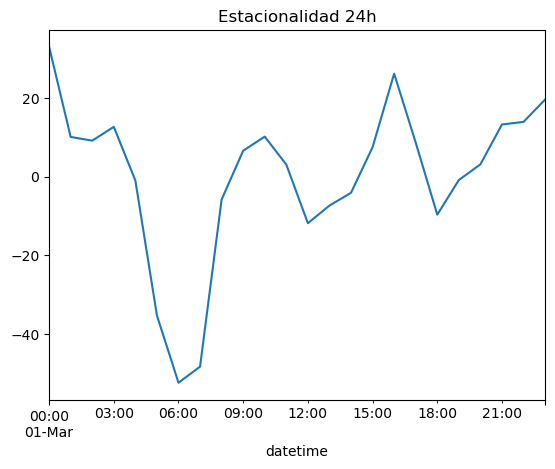

In [17]:
# Estacionalidad en un marco de 24 h
decomposed.seasonal[:24].plot()
plt.title('Estacionalidad 24h')

<span style=color:blue>**Comentario**</span>

- La tendencia es ascendente a través de los meses, siendo más alta a partir de junio.
- La estacionalidad, analizada en 24 h, muestra un aumentó de las órdenes de taxis a partir de las 7 am y disminuyendo luego de la media noche.

### Análisis de estacionariedad

Se utilizará la prueba de Dickey - Fuller para probar que la serie sea estacionaria

H0 : la serie temporal NO es estacionaria

In [18]:
# Prueba de Dickey - Fuller
alfa = 0.05
p_value = adfuller(data_hour)[1]

if p_value < alfa:
    print('La serie temporal Sí es estacionaria')
else:
    print('La serie temporal No es estacionaria')

La serie temporal Sí es estacionaria


### Autocorrelación

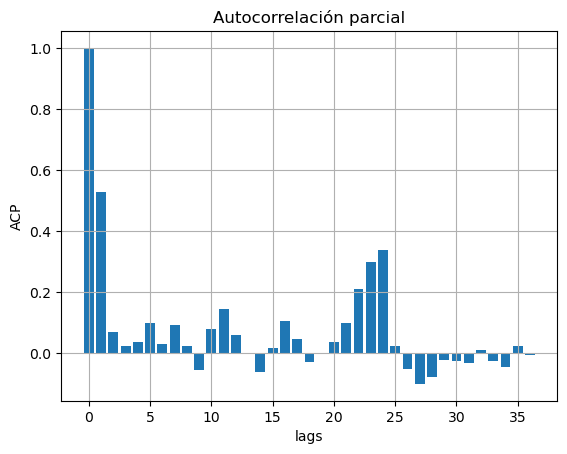

In [19]:
# Autocorrelación parcial
acp = pacf(data_hour, nlags=36)

plt.bar(
    x=range(37),
    height=acp
)
plt.grid()
plt.xlabel('lags')
plt.ylabel('ACP')
plt.title('Autocorrelación parcial')
plt.show()

<span style=color:blue>**Comentario**</span>

De acuerdo al gráfico de autocorrelación parcial, se utilizarán 24 lags, que muestran ser potencialmente útiles para el modelo predictivo.

## Ingeniería de datos

In [20]:
# Adición de hora, día de la semana y mes
df = data_hour.copy()

df['hour'] = df.index.hour
df['dow'] = df.index.day_of_week
df['month'] = df.index.month

df

,num_orders,hour,dow,month
datetime,,,,
2018-03-01 00:00:00,124,0,3,3
2018-03-01 01:00:00,85,1,3,3
2018-03-01 02:00:00,71,2,3,3
2018-03-01 03:00:00,66,3,3,3
2018-03-01 04:00:00,43,4,3,3
...,...,...,...,...
2018-08-31 19:00:00,136,19,4,8
2018-08-31 20:00:00,154,20,4,8
2018-08-31 21:00:00,159,21,4,8


In [21]:
# Adición de 24 lags como atributos
for l in range(24):
    df['lag_{}'.format(l+1)] = df['num_orders'].shift(l+1)

df.head(25)

,num_orders,hour,dow,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,3,3,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,3,3,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,7,3,3,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,8,3,3,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Adicionar media movil de 24 periodos

df['ma'] = df['num_orders'].shift().rolling(24).mean()

df.head(25)

,num_orders,hour,dow,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,ma
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,3,3,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,3,3,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,7,3,3,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,8,3,3,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Eliminar los valor ausentes
df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4392 non-null   int64  
 1   hour        4392 non-null   int32  
 2   dow         4392 non-null   int32  
 3   month       4392 non-null   int32  
 4   lag_1       4392 non-null   float64
 5   lag_2       4392 non-null   float64
 6   lag_3       4392 non-null   float64
 7   lag_4       4392 non-null   float64
 8   lag_5       4392 non-null   float64
 9   lag_6       4392 non-null   float64
 10  lag_7       4392 non-null   float64
 11  lag_8       4392 non-null   float64
 12  lag_9       4392 non-null   float64
 13  lag_10      4392 non-null   float64
 14  lag_11      4392 non-null   float64
 15  lag_12      4392 non-null   float64
 16  lag_13      4392 non-null   float64
 17  lag_14      4392 non-null   float64
 18  lag_15      4392 non-nul

## Modelos de regresión

In [24]:
# Separar atributos y target
X = df.drop(columns='num_orders')
y = df['num_orders']

Text(0.5, 1.0, 'Distribución de los datos target')

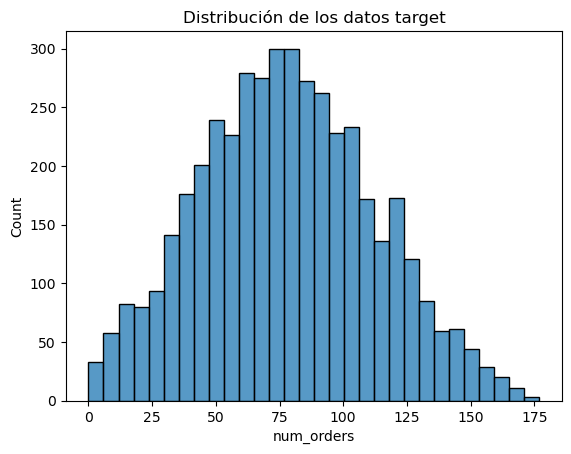

In [25]:
# Normalidad del target
sns.histplot(y)
plt.title('Distribución de los datos target')

<span style=color:blue>**Comentario**</span>

Los datos target tienen una distribución normal, por lo que no hace falta ningún ajuste en este sentido.

In [26]:
# Particionar datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=12345)

In [27]:
# Función para métricas r2 y RECM

def metricas(y_test, y_pred, imprimir=False):
    r2 = r2_score(y_test, y_pred)
    RECM = mean_squared_error(y_test, y_pred)**0.5

    if imprimir == True:
        print(f'r2: {r2:.1%}')
        print(f'RECM: {RECM:.4}')

    return r2, RECM

### Regresión lineal

In [28]:
# Creación de modelo de regresión lineal
modelo = LinearRegression().fit(X_train, y_train)

In [29]:
# Predicciones
y_pred = modelo.predict(X_test)

In [30]:
# Desempeño del modelo
metricas(y_test, y_pred, True)

r2: 19.8%
RECM: 29.12


(0.19771283961420272, 29.123690921884737)

<span style=color:blue>**Comentario**</span>

El modelo de regresión lineal generó predicciones con una RECM igual a 29.12 y un $r^2$ de 19.8%

In [31]:
# Contrastar la serie pura con la predicción del modelo
df_pred = pd.DataFrame(dict(
    Real = y_test,
    Predicho = y_pred,
), index= y_test.index)

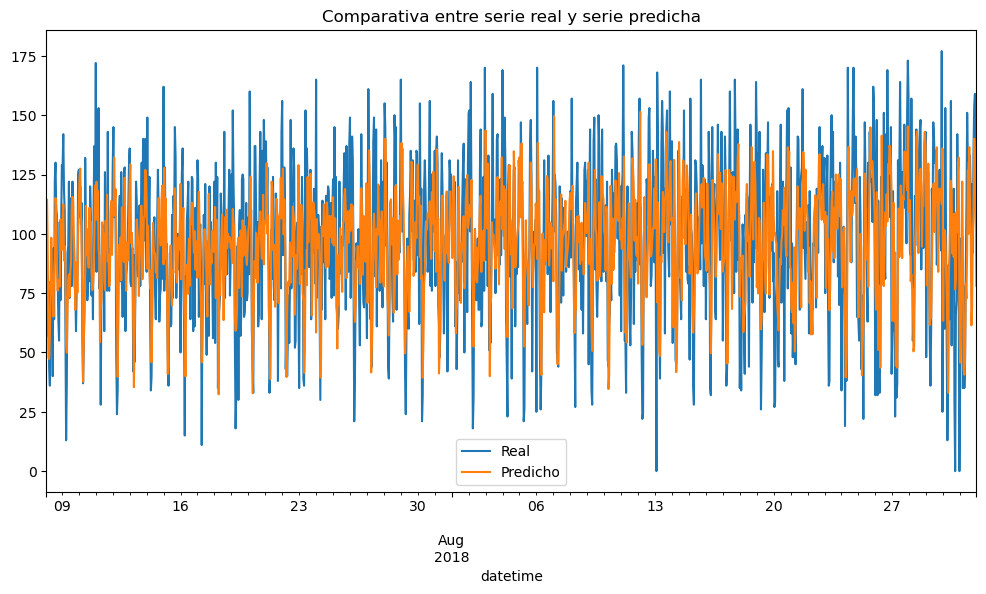

In [32]:
df_pred.plot(
    figsize=[12,6],
    title='Comparativa entre serie real y serie predicha'
)
plt.show()

<span style=color:blue>**Comentario**</span>

La serie predicha se aproxima a la real principalmente en los valores medios.

## Conclusiones

- La serie temporal tenía una distribución normal y era estacionaria (comprobado con la prueba Dickey - Fuller)
- El modelo de regresión lineal creado obtuvo una RECM igual a 29 taxis.
- Si bien el ajuste de los datos predichos, medido con el score $r^2$, es bajo respecto a los reales, el modelo de regresión lineal cumple satisfactoriamente el objetivo, al obtener una RECM menor al máximo solicitado de 48. 